# 2D CNN for MNIST digit recognition from scratch

<img src="images/mnist_sample.png" style="width:30%">

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import tensorflow as tf  # !pip install tensorflow
import numpy as np
import warnings
import sys
from PIL import Image

warnings.filterwarnings('ignore')  ## Never print matching warnings

tf.logging.set_verbosity(tf.logging.ERROR)  ## Control logging by filtering out ERROR logs

print("We're using TF", tf.__version__)
print("We're using Python", sys.version)

We're using TF 1.13.1
We're using Python 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]


# Looking at the data

In this task we have 55000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

X_train = mnist.train.images  ## numpy array of shape (55000, 784) i.e pixels pixels [0,1.0]
y_train = mnist.train.labels  ## numpy array of shape (55000, 10) i.e. one-hot encoded labels
# one-hot coding have 1 at corresponding position and zeros else
# examples:
#  0 is (1, 0, 0, 0, 0, 0, 0, 0, 0, 0,)
#  1 is (0, 1, 0, 0, 0, 0, 0, 0, 0, 0,)
#  2 is (0, 0, 1, 0, 0, 0, 0, 0, 0, 0,)
# ...
#  9 is (0, 0, 0, 0, 0, 0, 0, 0, 0, 1,)

X_test = mnist.test.images
y_test = mnist.test.labels

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


X_train [shape (55000, 784)]  whole sample:


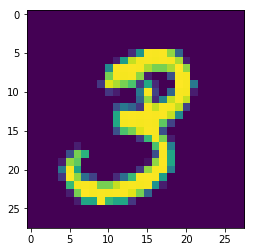

y_train [shape (55000, 10)] 1 samples:
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [3]:
# Images are already flattened which means that our linear model implementation now is simplified
print("X_train [shape %s]  whole sample:" % (str(X_train.shape)))
def show_img(sample):
    pixels = np.array(sample, dtype = 'float32')
    pixels = pixels.reshape((28,28))
    plt.imshow(pixels)
    plt.show()
show_img(X_train[1, :])
print("y_train [shape %s] 1 samples:\n" % (str(y_train.shape)), y_train[1])

# Logistic regression with 2D CNN

Here we will train a linear classifier $\vec{x} \rightarrow y$ with SGD using low-level TensorFlow.

First, we need to calculate a logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$
```python
logits = X @ W1 + b1  ### logits for input_X, resulting shape should be [input_X.shape[0], 256]
```
Then, we transform these logits $z_k$ to a valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$
```python
def softmax(z):  ## this approach provides numerical stability
    """Compute softmax values for each sets of scores in z."""
    e = tf.exp(z - tf.reduce_max(z))
    return e / tf.reduce_sum(e)
```
In order to avoid numerical overflow we use numerically stable sigmoid function:
$$p_k=\frac{1}{1+e^{-z_k}}=\frac{e^{z_k}}{1 + e^{z_k}} \quad k = 0..9$$
where the distributions $[z_k,0]$ and $[0,−z_k]$ are equivalent.
```python
def sigmoid(z):
    """Numerically stable sigmoid function."""
    # if z is less than zero then z will be small, denom can't be
    # zero because it's 1+z.
    return tf.where(z >= 0, 1 / (1 + tf.exp(-z)), tf.exp(z) / (1 + tf.exp(z))) 
```

Finally, We use a cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.
```python
# The loss should be a scalar number: average loss over all the objects with tf.reduce_mean().
cost = tf.reduce_mean(-tf.reduce_sum(y * tf.log(softmax(y_pred)), reduction_indices=[1]))
```
Here's our plan:
* We use a matrix placeholder for flattened `X_train` (28x28 = 784)
* Convert `y_train` to one-hot (already done) encoded vectors that are needed for cross-entropy
* We use a shared variable `W` for all weights (a column $\vec{w_k}$ per class) and `b` for all biases.
* Our aim is: $\text{test accuracy} \geq 0.95$

In [4]:
# Placeholders for the input data
# first shape is None means that the batch size will be specified at runtime
X = tf.placeholder(tf.float32, shape=(None, 784), name='X')
y = tf.placeholder(tf.float32, shape=(None, 10), name='y')

In [5]:
### Model parameters: W and b
# The initializer Xavier Glorot and Yoshua Bengio (2010) is designed to keep the 
# Scale of the gradients roughly the same in all layers
# Zeros_initializer is used for initializing the bias with zero


# 1st hidden layer
W1 = tf.get_variable("W1", shape=(784, 256), dtype=tf.float32, initializer = tf.contrib.layers.xavier_initializer())
b1 = tf.get_variable("b1", shape=(256), dtype=tf.float32, initializer = tf.zeros_initializer)

# 2nd hidden layer
W2 = tf.get_variable("W2", shape=(256, 10), dtype=tf.float32, initializer = tf.contrib.layers.xavier_initializer())
b2 = tf.get_variable("b2", shape=(10), dtype=tf.float32, initializer = tf.zeros_initializer)

def sigmoid(z):
    """Numerically stable sigmoid function."""
    # if z is less than zero then z will be small, denom can't be
    # zero because it's 1+z.
    return tf.where(z >= 0, 1 / (1 + tf.exp(-z)), tf.exp(z) / (1 + tf.exp(z))) 

### Compute predictions
logits = X @ W1 + b1  ### logits for input_X, resulting shape should be [input_X.shape[0], 256]
probas = tf.nn.sigmoid(logits)  ### apply tf.nn.softmax to logits
y_pred = probas @ W2 + b2  ### logits for probabilities, resulting shape should be [256, 10]

def softmax(z):  ## this approach provides numerical stability
    """Compute softmax values for each sets of scores in z."""
    e = tf.exp(z - tf.reduce_max(z))
    return e / tf.reduce_sum(e)

### Cross-Entropy loss 
# Hint: use tf.reduce_mean, tf.reduce_sum for reduction by specified axis
# The loss should be a scalar number: average loss over all the objects with tf.reduce_mean().
cost = tf.reduce_mean(-tf.reduce_sum(y * tf.log(softmax(y_pred)), reduction_indices=[1]))
#tf.nn.softmax(y_pred)
# We use a default tf.train.AdamOptimizer to get an SGD step
lr = 0.01
optimizer = tf.train.AdamOptimizer(lr)
step = optimizer.minimize(cost)  ### optimizer step that minimizes the loss (cost)

In [6]:
grads = tf.gradients(cost, tf.trainable_variables()) # take gradient of ALL TRAINABLES variables
grad_list = list(zip(grads, tf.trainable_variables()))

update = optimizer.apply_gradients(grads_and_vars=grad_list) # don't rename this op

### Apply tf.argmax to find a class index with highest probability
pred_classes = tf.argmax(y_pred, axis=1)  ## class index with highest probability for the predictions
true_classes = tf.argmax(y, axis=1)  ## class index with highest probability for the true outcome
pred = tf.cast(tf.equal(pred_classes, true_classes), dtype=tf.float32)
acc = tf.reduce_mean(pred) # don't rename this op

## Training

In [7]:
# We use in this part only train data! and never use test data
# We should split the data into mini-batches.

# The smaller the batch the less accurate the estimate of the gradient will be. And limited by your GPU memory
BATCH_SIZE = 512  ## Number of samples that will be propagated through the network
EPOCHS= 140 # 1 Epoch is view of all elements in dataset 1 time
BATCH_NUM = int(X_train.shape[0]/BATCH_SIZE)  # Here you loose the rest of batch you can add it

# Add an Op to initialize global variables.
init_op = tf.global_variables_initializer()
sess = tf.Session()  ## Launch the graph in a session.
sess.run(init_op)  ## # Run the Op that initializes global variables.

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    err = 0
    for batch in range(BATCH_NUM):
        # extract a batch
        batch_X = X_train[batch*BATCH_SIZE : batch*BATCH_SIZE + BATCH_SIZE]
        batch_y = y_train[batch*BATCH_SIZE : batch*BATCH_SIZE + BATCH_SIZE]
        
        # a key operation. Run 'operations' and place data in placeholders 'X' and 'y'
        _, c = sess.run([update, cost], feed_dict={X:batch_X, y:batch_y})
        err += c
    err /= BATCH_NUM
    if epoch%20 == 9:
            print("Test cost after %d epochs: %.4f" %(epoch+1, err))
    
print("\nOPTIMIZATION DONE!")
acc_train = sess.run([acc], feed_dict={X: X_train, y: y_train})
print('Score = %f' %acc_train[0])

Test cost after 10 epochs: 6.3396
Test cost after 30 epochs: 6.2765
Test cost after 50 epochs: 6.2594
Test cost after 70 epochs: 6.2546
Test cost after 90 epochs: 6.2511
Test cost after 110 epochs: 6.2466
Test cost after 130 epochs: 6.2471

OPTIMIZATION DONE!
Score = 0.999800


Final output of accuracy is ~ 99.99%.

## Testing

In [36]:
img = np.invert(Image.open("images/test_img.png").convert('L')).ravel()

In [61]:
prediction = sess.run(tf.argmax(y_pred, 1), feed_dict={X: [img]})
print ("Prediction for test image:", np.squeeze(prediction))

Prediction for test image: 2
